# Private Synopsis

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/opendp/smartnoise-sdk/blob/main/sql/samples/Synopsis.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/Synopsis.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/Synopsis.ipynb">
      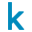
      Run on Kaggle
    </a>
  </td>                                                                                               
</table>

In [ ]:
!pip install smartnoise-sql pyspark --quiet

In [ ]:
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Download the Data

In [ ]:
from pathlib import Path
url_file = 'https://raw.githubusercontent.com/opendifferentialprivacy/dp-test-datasets/master/data/PUMS_california_demographics/data.csv'
local_file = Path('PUMS_large.csv')

!wget -nc {url_file} -O {str(local_file)}    

# Load the Data

First we load the California demographic data into a Spark `DataFrame`.  We let Spark infer the column names and types, then clean things up a bit.

In [ ]:
from pyspark.sql.types import FloatType, BooleanType

filepath = str(local_file)
pums = spark.read.load(filepath, format="csv", sep=",",inferSchema="true", header="true")

pums = pums.withColumnRenamed("_c0", "PersonID")

pums = pums.withColumn("income", col("income").cast(FloatType()))
pums = pums.withColumn("latino", col("latino").cast(BooleanType()))
pums = pums.withColumn("black", col("black").cast(BooleanType()))
pums = pums.withColumn("asian", col("asian").cast(BooleanType()))
pums = pums.withColumn("married", col("married").cast(BooleanType()))

pums.show(5)
print("There are {0} individuals in the data".format(pums.count()))

In [ ]:
from snsql import *
from pathlib import Path

metadata_path = Path("./PUMS_large.yaml")
metadata_string = """PUMS:
  PUMS:
    PUMS_large:
      clamp_counts: False
      censor_dims: False
      PersonID:
        type: int
        private_id: True
      state:
        type: int
      puma:
        type: string
      sex:
        type: string
      age:
        lower: 0
        upper: 100
        type: int
      educ:
        type: string
      income:
        lower: 0
        upper: 500000
        type: float
      latino:
        type: boolean
      black:
        type: boolean
      asian:
        type: boolean
      married:
        type: boolean
"""
with open(metadata_path, "w+") as f:
    f.write(metadata_string)

pums.createOrReplaceTempView("PUMS_large")

private_reader = from_connection(
    spark, 
    metadata=str(metadata_path), 
    privacy=Privacy(epsilon=3.0, delta=1/1_000_000)
)
private_reader.reader.compare.search_path = ["PUMS"]


res = private_reader.execute('SELECT COUNT(*) FROM PUMS_large')
res.show()

Each row in the data represents a unique individual.

# Get Exact Values for Comparison

The `private_reader` wraps an existing SparkSQL session and applies differential privacy.  We can access the underlying reader to get exact results with no differential privacy.  This is useful for comparing utility.  For example, we can compute the average income for individuals in the database.

In [ ]:
query = 'SELECT COUNT(*) AS count, AVG(income) FROM PUMS_large'

reader = private_reader.reader # the underlying connection to Spark SQL

res = reader.execute(query)
res.show()

# Generate Exact Synopsis

We can use the `SparkReader` to create a synopsis file that calculates some metrics grouped by the dimensions in the data.  We can then load the synopsis into an Excel spreadsheet to use in a Pivot Table, or query the synopsis from Pandas.

In [ ]:
query = 'SELECT sex, age, educ, married, latino, black, asian, COUNT(*) AS n, AVG(income) AS income FROM PUMS_large GROUP BY sex, age, educ, married, latino, black, asian ORDER BY n DESC'

synopsis = private_reader.reader.execute(query)
synopsis.show(15)
print("{0} distinct dimensions".format(synopsis.count()))

We now have far fewer rows, but we can still recover the exact values.  For example, the average income queried from our synopsis exactly matches the average income we queried above:

In [ ]:
synopsis.createOrReplaceTempView("Synopsis")

res = reader.execute("SELECT SUM(n) AS count, SUM(income * n) / SUM(n) AS avg_income FROM Synopsis")
res.show()

Note that we have gone from 1.2 million rows to approximately 20,000 rows, so each row in our synopsis no longer represents an individual.  However, we have still not attempted to use any differential privacy, so our synopsis is not private.  For example, there are several dimensions in our synopsis which uniquely identify individuals.

In [ ]:
reader.execute("SELECT * FROM Synopsis WHERE n <= 1").show(5)

Additionally, cells with exact counts > 1 can still leak privacy.  To protect against these and other attacks, let's make our synopsis private.

# Generate Private Synopsis

To generate a private synopsis, we use the same query we used to create the exact synopsis, but we use a `PrivateReader`, which transparently adds differential privacy.

In [ ]:
from pyspark.sql.types import DecimalType

private_synopsis = private_reader.execute(query) # using same query from before
private_synopsis = private_synopsis.withColumn('income', private_synopsis.income.cast(DecimalType(18, 2)))
private_synopsis.show(15)
print("{0} distinct dimensions".format(private_synopsis.count()))

Because the `PrivateReader` transparently adds noise, you will notice that the numbers change each time you run the cell above, sometimes even returning negative counts or negative incomes.  However, the larger aggregates are still fairly accurate, because the noise is symmetrical:

In [ ]:
private_synopsis.persist().createOrReplaceTempView("PrivateSynopsis")

reader.execute("SELECT SUM(n) AS count, SUM(income * n) / SUM(n) AS avg_income FROM PrivateSynopsis").show()


Notice that we call `persist()` when loading the private synopsis into a view.  This is how we ensure that Spark doesn't generate a new synopsis every time we query the synopsis.  The goal of a synopsis is to support many queries from a single generation, and we do not want to pay additional `epsilon` privacy cost every time we use the synopsis.  If we create the synopsis once, we can export to Excel or persist in a view, then query indefinitely without incurring further privacy cost.

## PrivateReader Parameters

When we created the `PrivateReader` above, we passed in the `epsilon` parameter and wrapped our existing `SparkReader` we created earlier.  The `PrivateReader` simply intercepts calls to `SparkReader` and adds noise calibrated to the requested `epsilon`.  We also passed in some metadata describing the sensitivity of the fields in the data source, loaded from a YAML file.  In particular, the algorithm needed to know that the `income` field ranges between 0 and 500,000, in order to appropriately calibrate the noise:

In [ ]:
import snsql
meta = snsql.metadata.Metadata.from_file(metadata_path)
print(meta)

Also notice that the YAML file refers to the PUMS_large table with the prefix PUMS, which is a convention used in the SQL-92 specification allowing tables and views to be grouped together.  Although we are only querying a single source table here, the readers support querying over multiple tables.  Since our query does not specify the full disambiguated table name, we tell our reader to treat PUMS as a default namespace by specifying `private.reader.compare.search_path`.

You can read more about the other `PrivateReader` options [here](https://opendifferentialprivacy.github.io/smartnoise-samples/docs/api/system/sql/private_reader.html#opendp.smartnoise.sql.private_reader.PrivateReaderOptions)

# Censoring Infrequent Dimensions

One option worth exploring further is the `censor_dims` option we set to `False` above.  Recall that the number of distinct dimensions in our private synopsis was exactly the same as the number of distinct dimesions in our exact synopsis.  In our exact synopsis, the existence of dimensions with exactly one member constituted a privacy leak.  Since we have added noise, dimensions with fewer than 2 members are significantly less useful:


In [ ]:
reader.execute("SELECT * FROM PrivateSynopsis WHERE n <= 1").show(8)

However, it is possible that the mere existence of a unique dimension combination in the data set would constitute a privacy failure.  For example, if this data represented people with a sensitive medical condition, mere membership would sensitive.  If we want to protect the queries further, we can tell the system to hide infrequent dimensions, adhering to epsilon, delta differential privacy.

In [ ]:
print(query)
delta = 1/1_200_000

meta["PUMS.PUMS_large"].censor_dims = True

private_reader = from_connection(
    spark, 
    metadata=meta,
    privacy=Privacy(epsilon=3.0, delta=delta)
)
private_reader.reader
private_reader.reader.compare.search_path = ["PUMS"]


private_synopsis = private_reader.execute(query)
print("{0} distinct dimensions".format(private_synopsis.count()))

In [ ]:
private_synopsis.persist().createOrReplaceTempView("PrivateSynopsis")

reader.execute("SELECT SUM(n) AS count, SUM(income * n) / SUM(n) AS avg_income FROM PrivateSynopsis").show()

From the outputs, you can see the private synopsis still computes an accurate average income, but we are missing about 6,500 dimensions, representing about 12,000 individuals.  It may be desirable to leave the synopsis like this, to indicate that some individuals have been dropped for privacy reasons.  In some settings, however, this is undesirable, because aggregate counts will be biased downward.  To resolve this, we can add an `other` dimension that recaptures the dropped dimension.

## Recovering Infrequent Dimensions

In [ ]:
# get the dimensions
other = 'SELECT DISTINCT sex, age, educ, married, latino, black, asian FROM PUMS_large EXCEPT (SELECT DISTINCT sex, age, educ, married, latino, black, asian FROM PrivateSynopsis)'
other_dims = reader.execute(other)
other_dims.persist().createOrReplaceTempView("OtherDims")
print("Combining {0} distinct dimensions that were dropped.".format(other_dims.count()))

# get rows that match censored dimensions
filtered = 'SELECT t1.* FROM PUMS_large t1 LEFT SEMI JOIN OtherDims t2 ON ( t1.sex = t2.sex AND t1.age = t2.age AND t1.educ = t2.educ AND t1.married = t2.married AND t1.latino = t2.latino AND t1.black = t2.black AND t1.asian = t2.asian)'
filtered_pums = reader.execute(filtered)
filtered_pums.persist().createOrReplaceTempView("PUMS_censored")
print("Selecting {0} records from the dimensions that were censored".format(filtered_pums.count()))

We now have a table, `PUMS_censored`, which has all the records which were censored from our private synopsis.  We can create a differentially private result, treating all of our censored dimensions as a single `other` dimension.  To query these remaining records, we need metadata that describes the new table, `PUMS_censored`.  Since this has the same schema as `PUMS_large`, we can grab the original schema and make a copy for the new table.

In [ ]:
import copy
pc = copy.copy(meta.m_tables['PUMS.PUMS_large'])
pc.name = 'PUMS_censored'
meta.m_tables['PUMS.PUMS_censored'] = pc

In [ ]:
query_single = 'SELECT COUNT(*) AS n, AVG(income) AS income FROM PUMS_censored'
missing_dim = private_reader.execute(query_single).persist()
missing_dim.createOrReplaceTempView("Censored")
missing_dim.show()


# Noisy Values for Missing Dimensions

Another option is to create a private synopsis for all possible dimension values, where missing values will be set to NULL, which will result in zero counts.  These zero counts will result in zero values.  This approach is not suitable in settings where rare dimensions are private, such as surnames, or when the cross product of all dimensions is very large.  In this case, however, the distinct dimension members are not private, and the cross product is not large.

In [ ]:
alldims = 'SELECT s.*, a.*, e.*, m.*, l.*, b.*, asi.* \
    FROM (SELECT DISTINCT sex FROM PUMS_large) s \
    CROSS JOIN (SELECT DISTINCT age FROM PUMS_large) a \
    CROSS JOIN (SELECT DISTINCT educ FROM PUMS_large) e \
    CROSS JOIN (SELECT DISTINCT married FROM PUMS_large) m \
    CROSS JOIN (SELECT DISTINCT latino FROM PUMS_large) l \
    CROSS JOIN (SELECT DISTINCT black FROM PUMS_large) b \
    CROSS JOIN (SELECT DISTINCT asian FROM PUMS_large) asi'

all_dims = reader.execute(alldims)
all_dims.persist().createOrReplaceTempView("AllDims")

print("Including empty dimensions, there are {0} total dimensions".format(all_dims.count()))

Adding the empty dimensions increases our total number of dimensions by about 16,000.

In [ ]:
joined = 'SELECT p.PersonID, p.state, p.puma, d.sex, d.age, d.educ, d.latino, d.black, d.asian, d.married, p.income \
    FROM AllDims d LEFT OUTER JOIN PUMS_large p ON \
        d.sex = p.sex AND \
        d.age = p.age AND \
        d.educ = p.educ AND \
        d.latino = p.latino AND \
        d.black = p.black AND \
        d.asian = p.asian AND \
        d.married = p.married'

joined_pums = reader.execute(joined).persist()
joined_pums.createOrReplaceTempView("PUMS_joined")
print("There are {0} rows, including empty dimensions".format(joined_pums.count()))



In [ ]:
pc = copy.copy(meta.m_tables['PUMS.PUMS_large'])
pc.name = 'PUMS_joined'
meta.m_tables['PUMS.PUMS_joined'] = pc

In [ ]:
meta["PUMS.PUMS_large"].censor_dims = False
meta["PUMS.PUMS_large"].clamp_counts = False
meta["PUMS.PUMS_large"].row_privacy = True


q = 'SELECT sex, age, educ, married, latino, black, asian, COUNT(*) AS n, AVG(income) AS income FROM PUMS_joined GROUP BY sex, age, educ, married, latino, black, asian'

priv2 = private_reader.execute(q).persist()
priv2.createOrReplaceTempView("PrivateSynopsis2")
print("The new private synopsis has {0} dimensions".format(priv2.count()))
reader.execute("SELECT SUM(n) AS count, SUM(income * n) / SUM(n) AS avg_income FROM PrivateSynopsis2").show()
